#### Data Dictionary

Survival  (0 = No, 1 = Yes)    
Pclass    (1 = 1st Upper, 2 = 2nd Middle, 3 = 3rd Lower)   
Sex       (gender)    
Age       (in years)     
Sibsp     (of siblings / spouses aboard the Titanic)      
Parch     (of parents / children aboard the Titanic)      
Ticket    (ticket number)      
Fare      (passenger fare)     
Cabin     (cabin number)      
Embarked  (C = Cherbourg, Q = Queenstown, S = Southampton)      

#### Variable Notes

sibsp:   
Sibling = brother, sister, stepbrother, stepsister   
Spouse = husband, wife (mistresses and fiancés were ignored)   

parch:    
Parent = mother, father   
Child = daughter, son, stepdaughter, stepson   
Some children travelled only with a nanny, therefore parch=0 for them.   

train.csv - training set - тренировочный набор данных. В них известен ответ - survival   
test.csv - test set - тестовый набор данных. Ответ не известен. На них проверяется качество построенной модели.   
gender_submission.csv - пример формата данных, которые нужно отправить на kaggle.   

#### Алгоритм работы:  

* изучаем и преобразуем данные из train.csv
* строим модель и подбираем параметры, выбираем лучшую модель на преобразованных данных из train.csv
* фиксируем метод преобразований и модель
* применяем те же самые преобразования на test.csv  
* применяем модель на test.csv
* результат применения сохраняем файл в таком же формате как и в gender_submission.csv
* отправляем на kaggle
* повторяем все пункты (помним, что нельзя подбирать параметры модели делая submit - высокий риск переобучиться)

In [17]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas_profiling

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

%matplotlib inline

#### Загружаем данные

In [3]:
df_train = pd.read_csv('train.csv', na_values='NaN')
df_train[0:3]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
df_test = pd.read_csv('test.csv')
df_test[0:3]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


#### Воспользуемся библиотекой pandas_profiling 

pandas_profiling.ProfileReport(df_train)

 ### План по преобразованию признаков
 
  * Sex - One Hot Encoder  
  * Создать новый признак - сколько всего родственников на борту
  * Создать новый признак - человек едет один
  * Добавить колонку едет с мамой(для детей до 15 лет)/едет с ребенком(для женщин старше 20)
  * Создать новый признак Title
  * Title - One Hot Encoder
  * Заменить пропущенные значения Age на медиану по титулу
  * Добавить дополнительную переменную median_Age в зависимости от тутула
  * Ticket - LabelEncoder
  * Embarkment - заменить пропуски на 'U' и LabelEncoder
  * Embarkment - One Hot Encoder
  * Cabin - заменить пропуски на 'U' и LabelEncoder
  * Cabin - One Hot Encoder
  * Fare - заменить пропуски на медиану 
  * Создать новые признаки - нормализация medianAge и medianFare
  * Удалить категориальные признаки
 

In [6]:
def normalization(var) :
    norm = (var - var.mean()) / var.std()
    return norm

In [7]:
def transform_data(data):
  
    # Sex - One Hot Encoder
    gender_dummies = pd.get_dummies(data["Sex"], dummy_na=False).astype(int)
    data = pd.concat([data, gender_dummies], axis=1)
    
    # Количество родственников на борту
    data["Relatives"] = data["Parch"] + data["SibSp"]

    # Человек-одиночка?
    data["Single"] = data["Relatives"].apply(lambda r: 1 if r == 0 else 0)
    
    # У человека есть на борту мама или ребенок
    child = data[(data.Age < 15) & ((data["Parch"] + data["SibSp"]) > 0)] 
    adult_women = data[(data.Age > 20) & ((data["Parch"] + data["SibSp"]) > 0) & (data['Sex'] == 'female')]
    relatives = pd.merge(child,adult_women, on=['Ticket'], how='inner')
    child = relatives['PassengerId_x']  
    adult_women = relatives['PassengerId_y']
    Pid = pd.concat([child, adult_women]).drop_duplicates()
    Pid = pd.DataFrame(data = Pid)
    Pid['PassengerId'] = Pid[0]
    Pid['mother_child'] = 1
    mother_child = Pid[['PassengerId','mother_child']]
    data = pd.merge(data,mother_child, on=['PassengerId'], how='left')
    data['mother_child'].fillna(0,inplace=True)
    
    # Добавим дополнительную колонку medianAge в зависимости от титула пассажира
    data['Title'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # map 
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "High title",
                        "Don":        "High title",
                        "Sir" :       "High title",
                        "Dr":         "Dr",
                        "Rev":        "Rev",
                        "the Countess":"High title",
                        "Dona":       "High title",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "High title"

                        }
    data['Title'] = data.Title.map(Title_Dictionary)
    data['medianAge'] = data.groupby('Title')['Age'].transform('median')
    # Title - One Hot Encoder
    title_dummies = pd.get_dummies(data["Title"], dummy_na=False).astype(int)
    data = pd.concat([data, title_dummies], axis=1)
    
    
     # Embarkment - замена 
    embarkments = {"U": 0, "S": 1, "C": 2, "Q": 3}
    data["Embarked_R"] = data["Embarked"].fillna("U").apply(lambda e: embarkments.get(e))

    # Embarkment - One Hot Encoder
    embarkment_dummies = pd.get_dummies(data["Embarked"].fillna("U").apply(lambda c: c[0]), prefix="Embarked", dummy_na=False).astype(int)
    data = pd.concat([data, embarkment_dummies], axis=1)
    
    # Cabin - замена
    cabin = {"U": 0, "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
    data["Cabin_R"] = data["Cabin"].fillna("U").apply(lambda c: cabin.get(c[0], -1))

    # Cabin - One Hot Encoder
    cabin_dummies = pd.get_dummies(data["Cabin"].fillna("U").apply(lambda c: c[0]), prefix="cabin", dummy_na=False).astype(int)
    data = pd.concat([data, cabin_dummies], axis=1)
    
    # Ticket Label Encoder Title, Ticket
    le.fit(data['Title'])
    data['Title'] = (le.transform(data['Title']))
    le.fit(data['Ticket'])
    data['Ticket'] = (le.transform(data['Ticket']))
    
    # Fare median
    data['medianFare'] = data['Fare'].fillna(data['Fare'].median())
    
    # Normalisation medianAge, medianFare
    data["medianAge"] = normalization(data["medianAge"])
    data["medianFare"] = normalization(data["medianFare"])
    data =  data.drop( ['Embarked','Name','Sex','Cabin','Fare','Age'],axis=1)
    
    return data

#### Обучение модели и Future Selection

 * KNN
 * Logistic Regression
 * Random Forest

In [8]:
transform_train = transform_data(df_train)
transform_test = transform_data(df_test)

In [9]:
X = transform_train.drop(('Survived'), axis=1)  
y = transform_train['Survived']
feature_names = X.columns

#### Для отбора признаков используем DecisionTreeClassifier

In [10]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
dtc = DecisionTreeClassifier( random_state=241)
dtc.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=241,
            splitter='best')

In [11]:
importance = dtc.feature_importances_
indices = np.argsort(importance)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importance[idx]))

Feature importances:
 1. feature 'Mr   ' (0.3016)
 2. feature 'Ticket' (0.1744)
 3. feature 'PassengerId' (0.1657)
 4. feature 'medianFare' (0.1326)
 5. feature 'Relatives' (0.0822)
 6. feature 'medianAge' (0.0351)
 7. feature 'Pclass' (0.0341)
 8. feature 'cabin_E' (0.0123)
 9. feature 'Parch' (0.0097)
10. feature 'Single' (0.0067)
11. feature 'Title' (0.0057)
12. feature 'cabin_A' (0.0050)
13. feature 'cabin_U' (0.0049)
14. feature 'cabin_D' (0.0048)
15. feature 'SibSp' (0.0047)
16. feature 'cabin_C' (0.0044)
17. feature 'Embarked_S' (0.0037)
18. feature 'Cabin_R' (0.0034)
19. feature 'Embarked_Q' (0.0021)
20. feature 'Rev  ' (0.0020)
21. feature 'mother_child' (0.0017)
22. feature 'female' (0.0014)
23. feature 'Embarked_C' (0.0012)
24. feature 'Embarked_R' (0.0005)
25. feature 'male ' (0.0000)
26. feature 'cabin_T' (0.0000)
27. feature 'cabin_F' (0.0000)
28. feature 'Miss ' (0.0000)
29. feature 'Dr   ' (0.0000)
30. feature 'High title' (0.0000)
31. feature 'Master' (0.0000)
32. feat

(-1, 36)

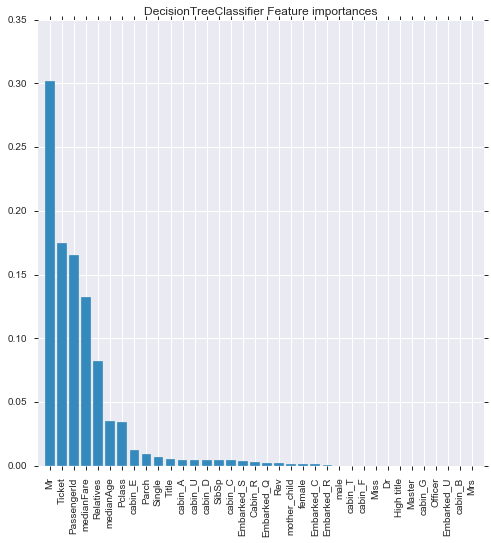

In [18]:
d_first = 36
plt.figure(figsize=(8, 8))
plt.title("DecisionTreeClassifier Feature importances")
plt.bar(range(d_first), importance[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first])

Для обучения модели возьмем признаки с важностью выше 0.0015

In [24]:
X_train = X[['Mr','Ticket','medianFare','Relatives', 'Pclass','medianAge','cabin_E','SibSp','Cabin_R','Embarked_Q','cabin_U','cabin_A','cabin_D','Title','cabin_C','female','Parch','Miss','mother_child']]
X_test = transform_test[['Mr','Ticket','medianFare','Relatives', 'Pclass','medianAge','cabin_E','SibSp','Cabin_R','Embarked_Q','cabin_U','cabin_A','cabin_D','Title','cabin_C','female','Parch','Miss','mother_child']]

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

In [41]:
# initialise classifiers
knn = KNeighborsClassifier()
logr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=400, 
                            random_state=11,
                            criterion='gini')

In [44]:
# score using cross validation
clf_list = [knn, logr, rf]
name_list = ['KNN','Logistic Regression','Random Forest']

for clf, name in zip(clf_list,name_list) :
    scores = model_selection.cross_val_score(clf, X_train, y, cv=10)
    print("Accuracy: %0.2f +/- %0.2f (%s)" % (scores.mean(), scores.std()*2, name))

Accuracy: 0.71 +/- 0.09 (KNN)
Accuracy: 0.82 +/- 0.08 (Logistic Regression)
Accuracy: 0.81 +/- 0.08 (Random Forest)


Засабмитила все, лучше всего предсказывает всё таки Random Forest

#### Random Forest

In [43]:
rf.fit(X_train, y)

prediction_rf = rf.predict(X_test)
df_predicted = pd.DataFrame({'PassengerId': transform_test['PassengerId'], 'Survived': prediction_rf})
df_predicted.to_csv('rf.csv', sep=',', index=False)

0.79904
https://www.kaggle.com/kateshvorneva